# Traing RL Agent to play PONG using NN and Policy Gradients

**STEP 1.** Checking the available GPU devices

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Mon Mar  6 19:14:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   7095MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**STEP 2.** Installing the required libraries/packages

In [ ]:
!pip install gym[atari]
!pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached libtorrent-2.0.7-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.5-py3-none-any.whl size=448855 sha256=8a0e01b6d4abae93a74f7276349a31aa1872fd01b5d996b145e5a5c7196b517d
  Stored in directory: /root/.cache/pip/wheels/55/da/0f/2171aa233043791a9e688909cbafe26266cb4fe1d2e8ff3ff9
Successfully built AutoROM.accept-rom-license


**STEP 3.** Importing the required libraries 

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from datetime import datetime
import tensorflow as tf
from keras.models import load_model
import glob
import os


**STEP 4.** Setting the random seed

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

**STEP 5.** Defining the hyperparameters

In [ ]:
learning_rate = 0.001
discount_factor = 0.99
num_episodes = 3000
num_steps = 10000
render_env = False

**STEP 6.** Defining the optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

**STEP 7.** Initializing the gym PONG environment

In [ ]:
env = gym.make('Pong-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n

**STEP 7.** Building the NN Model and compiling

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, kernel_size=8, strides=4, activation='relu', input_shape=state_size),
  tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(action_size, activation='softmax')
])
print(f'Model built from scratch')
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model built from scratch


**STEP 8.** Defining the Training function

In [ ]:
@tf.function(reduce_retracing=True)
def train_step(states, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        # Get action probabilities for given states
        logits = model(states)
        action_probabilities = tf.nn.softmax(logits)

        # Compute loss
        cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(
            actions, action_probabilities, from_logits=False)
        loss = tf.reduce_mean(cross_entropy * discounted_rewards)

    # Compute gradients and update weights
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

**STEP 8.** Defining the Training loop (Agent plays Pong) 

In [ ]:
with tf.device('GPU:0'):
    # Loop to train
    for episode in range(num_episodes):
        episode_rewards, episode_actions, episode_states = [], [], []
        state = env.reset()
        for step in range(num_steps):
            if render_env:
                env.render()

            # Action probabilities for given state
            state = np.expand_dims(state, axis=0).astype(np.float32)
            logits = model(state)
            action_probabilities = tf.nn.softmax(logits).numpy()[0]

            # Sampling action from action probabilities
            action = np.random.choice(action_size, p=action_probabilities)

            # Performing action to fetch next state and reward
            next_state, reward, done, info = env.step(action)

            # Saving info for each episode 
            episode_rewards.append(reward)
            episode_actions.append(action)
            episode_states.append(state)

            if done:
                # Computing rewards-to-go
                rewards_to_go = np.zeros_like(episode_rewards)
                cumulative_reward = 0
                for i in reversed(range(len(episode_rewards))):
                    cumulative_reward = cumulative_reward * discount_factor + episode_rewards[i]
                    rewards_to_go[i] = cumulative_reward

                # Normalizing rewards-to-go
                rewards_to_go -= np.mean(rewards_to_go)
                rewards_to_go /= np.std(rewards_to_go)

                # Training policy network using rewards-to-go
                episode_states = np.concatenate(episode_states, axis=0)
                episode_actions = np.array(episode_actions)
                rewards_to_go = rewards_to_go.astype(np.float32)
                train_step(episode_states, episode_actions, rewards_to_go)

                # Printing reward info for each episode
                print("Episode:", episode + 1, "Reward:", sum(episode_rewards))
                if (episode + 1) % 50 == 0:
                    model.save(f'Pong_PolicyGrad_model_episode_{episode+1}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5')
                break

            # Update state
            state = next_state

# Close environment
env.close()

Episode: 1 Reward: -20.0
Episode: 2 Reward: -20.0
Episode: 3 Reward: -20.0
Episode: 4 Reward: -20.0
Episode: 5 Reward: -21.0
Episode: 6 Reward: -20.0
Episode: 7 Reward: -20.0
Episode: 8 Reward: -21.0
Episode: 9 Reward: -20.0
Episode: 10 Reward: -20.0
Episode: 11 Reward: -21.0
Episode: 12 Reward: -20.0
Episode: 13 Reward: -21.0
Episode: 14 Reward: -21.0
Episode: 15 Reward: -20.0
Episode: 16 Reward: -21.0
Episode: 17 Reward: -21.0
Episode: 18 Reward: -21.0
Episode: 19 Reward: -21.0
Episode: 20 Reward: -20.0
Episode: 21 Reward: -20.0
Episode: 22 Reward: -20.0
Episode: 23 Reward: -20.0
Episode: 24 Reward: -20.0
Episode: 25 Reward: -20.0
Episode: 26 Reward: -21.0
Episode: 27 Reward: -21.0
Episode: 28 Reward: -20.0
Episode: 29 Reward: -20.0
Episode: 30 Reward: -21.0
Episode: 31 Reward: -21.0
Episode: 32 Reward: -20.0
Episode: 33 Reward: -20.0
Episode: 34 Reward: -21.0
Episode: 35 Reward: -20.0
Episode: 36 Reward: -21.0
Episode: 37 Reward: -21.0
Episode: 38 Reward: -19.0
Episode: 39 Reward: -

**STEP 9.** Testing/Visualizing the trained agent/model (Agent plays Pong) 

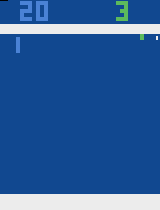

In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import gym
from keras.models import load_model
import numpy as np
import tensorflow as tf

# Loading the saved/trained model
#model = load_model('Pong_PolicyGrad_model_episode_150_2023-03-06_19-13-23.h5')
model = load_model('Pong_PolicyGrad_model_episode_750_2023-03-10_14-31-30.h5')

# Initializing the environment
env = gym.make('Pong-v0')

# Playing Pong with saved/trained model
obs = env.reset()
done = False

while not done:
    # Clearing previous frame & rendering the environment
    clear_output(wait=True)
    cv2_imshow(env.render(mode='rgb_array'))

    # Action probabilities for the given state
    obs = np.expand_dims(obs, axis=0).astype(np.float32)
    logits = model(obs)
    action_probabilities = tf.nn.softmax(logits).numpy()[0]

    # Sampling action from action probabilities
    action = np.random.choice(env.action_space.n, p=action_probabilities)

    # Performing action to fetch next state and reward
    obs, reward, done, info = env.step(action)

# Finally, closing the environment
env.close()

**STEP 10.** Saving Test game played by the trained agent/model (Agent plays Pong) 

In [ ]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [ ]:
import gym
import numpy as np
from keras.models import load_model
from gym.wrappers import RecordVideo

# Load trained model
#model = load_model('Pong_PolicyGrad_model_episode_50_2023-03-06_14-31-30.h5')
model = load_model('Pong_PolicyGrad_model_episode_750_2023-03-10_14-31-30.h5')

# Initialize Pong environment
env = gym.make('Pong-v0')

# Wrap environment to record video
env = RecordVideo(env, 'test_video/video.mp4')

# Play Pong with trained model
obs = env.reset()
done = False
while not done:
    # Render the environment
    env.render()

    # Get action probabilities for given state
    obs = np.expand_dims(obs, axis=0).astype(np.float32)
    logits = model(obs)
    action_probabilities = tf.nn.softmax(logits).numpy()[0]

    # Sample action from action probabilities
    action = np.random.choice(env.action_space.n, p=action_probabilities)

    # Perform action and get next state and reward
    obs, reward, done, info = env.step(action)

# Close the environment
env.close()



/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/test_video/video.mp4 folder (try specifying a different `video_folder` for the 